In [1]:

#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import scipy.io as scio 
import scipy.io as sio
from tf_utils import random_mini_batches_GCN
from tensorflow.python.framework import ops
import hdf5storage



In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

def create_placeholders(n_x, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.placeholder(tf.float32, [None, None], name = "lap_train")
    
    return x_in, y_in, lap_train, isTraining

def initialize_parameters():
   
    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [200,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())

    x_w2 = tf.get_variable("x_w2", [128,16], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b2 = tf.get_variable("x_b2", [16], initializer = tf.zeros_initializer())    

    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters




In [3]:
def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.name_scope("x_layer_1"):

         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)             
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)      
         
    with tf.name_scope("x_layer_3"):
        
         x_z2_bn = tf.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)        
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss

def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
    
    y_re = tf.squeeze(y_re, name = 'y_re')
    
    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss
         
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

def network_accuracy(x_out, y_in):
    
    correct_prediction = tf.equal(tf.argmax(x_out, 1), tf.argmax(y_in, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    return accuracy
    


In [4]:
def train_mynetwork(x_train, x_test, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    tf.compat.v1.disable_eager_execution()
    ops.reset_default_graph()    
    tf.set_random_seed(1)                          
    seed = 1                                                         
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap_train, isTraining = create_placeholders(n_x, n_y) 

    parameters = initialize_parameters()
    
    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         accuracy = network_accuracy(x_out, y_in)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
      
        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.
            epoch_acc = 0.
            
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            
            minibatches = random_mini_batches_GCN(x_train, y_train, L_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, y_in: batch_y, lap_train: batch_l, isTraining: True})           
                epoch_cost += minibatch_cost 
                epoch_acc += minibatch_acc

            epoch_cost_train = epoch_cost / (num_minibatches+ 1) 
            epoch_acc_train = epoch_acc / (num_minibatches+ 1) 

           
            if print_cost == True and epoch % 50 == 0:
                features, epoch_cost_test, epoch_acc_test = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_test, epoch_acc_train, epoch_acc_test))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_test)
                val_acc.append(epoch_acc_test)

        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
      
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
       
        return parameters, val_acc, features




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_4368/1346198285.py:12: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)
/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_4368/1346198285.py:14: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
/var/folders/z_/krw1gf615x7gd0lvqxvzk

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 03:15:20.411420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 03:15:20.411553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-03 03:15:20.416785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-03 03:15:20.428883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-03 03:15:20.430437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 03:15:20.593443: I tensorflow/core/grappler/optimizers/custom_graph

epoch 0: Train_loss: 2.247364, Val_loss: 1.774535, Train_acc: 0.294077, Val_acc: 0.285493
epoch 50: Train_loss: 0.493474, Val_loss: 1.253032, Train_acc: 0.873778, Val_acc: 0.728570
epoch 100: Train_loss: 0.330563, Val_loss: 1.575556, Train_acc: 0.934894, Val_acc: 0.728984
epoch 150: Train_loss: 0.256958, Val_loss: 1.483398, Train_acc: 0.960920, Val_acc: 0.747182
epoch 200: Train_loss: 0.217441, Val_loss: 1.528923, Train_acc: 0.971910, Val_acc: 0.749767


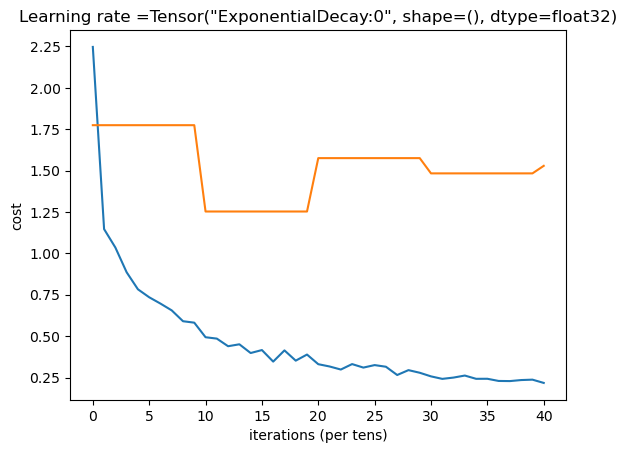

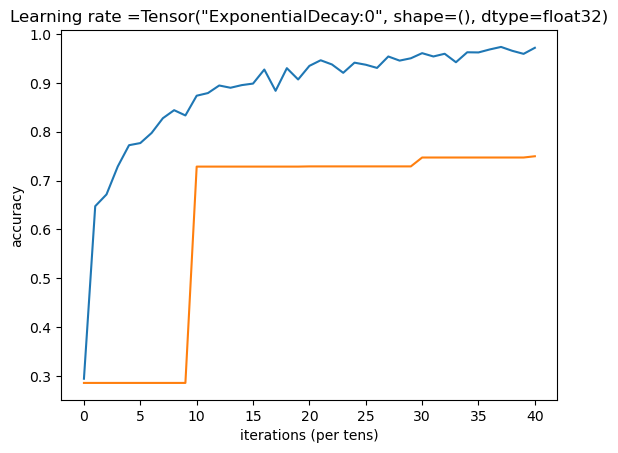

Parameters have been trained!


2023-02-03 03:16:18.171130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [5]:
Train_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TrLabel.mat')
Test_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TeLabel.mat')
Train_L = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/fea_a/Binary/Train_L.mat')
Test_L = hdf5storage.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/fea_a/Binary/Test_L.mat')


Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']

TrLabel = convert_to_one_hot(TrLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = convert_to_one_hot(TeLabel-1, 16)   
TeLabel = TeLabel.T


parameters, val_acc, features = train_mynetwork(Train_X, Test_X, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/k10/features-miniGCN_feaa_B.mat', {'features': features})